In [1]:
!nvidia-smi | head -n 32

Wed Mar 21 12:38:38 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 49%   72C    P8    27W / 250W |    449MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:42:00.0 Off |                  N/A |
| 25%   45C    P8    17W / 250W |  11042MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import sys
import os
sys.path.append('../common/')
import utils
import nets
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time
import random
plt.style.use('ggplot')
import traceback
import math
print(tf.__version__)

1.3.0


In [3]:
MODEL_NAME = '3_22_rpn_sigmoid_transfer'

In [4]:
#REMOTE_WORKER = "grpc://10.109.246.6:2222"
#cluster = tf.train.ClusterSpec({"local": ["10.109.246.6:2222"]})

In [5]:
import pickle
with open('../data/train_val.pkl','rb') as fhdl:
    (train_images,train_bbs,val_images,val_bbs) = pickle.load(fhdl)

In [6]:
BATCH_SIZE = 1

In [7]:
?tf.layers.conv2d

In [8]:
def rpn_layer(feature_map,k=9,ramda=10):
    mask_input = tf.placeholder(tf.float32,shape=(BATCH_SIZE,None,None,1 * k),name='mask_input')
    cls_input = tf.placeholder(tf.float32,shape=(BATCH_SIZE,None,None,k),name='cls_input')
    reg_input = tf.placeholder(tf.float32,shape=(BATCH_SIZE,None,None,k * 4),name='reg_input')
    
    with tf.variable_scope('rpn_conv'):
        rpn_hidden = tf.layers.conv2d(feature_map,filters=256,kernel_size=(3,3),padding='same',activation=tf.nn.relu,name='hidden')
        cls_result = tf.layers.conv2d(rpn_hidden,filters=k,kernel_size=(1,1),padding='same',activation=None,name='cls_conv') # [BATCH_SIZE,None,None,4 * k]
        reg_result = tf.layers.conv2d(rpn_hidden,filters=4 * k,kernel_size=(1,1),padding='same',activation=None,name='reg_conv') # [BATCH_SIZE,None,None,4 * k]

    with tf.variable_scope('rpn_loss'):
        #cls_input_reshape = tf.reshape(cls_input,shape=(-1,2))
        #cls_result_reshape = tf.reshape(cls_result,shape=(-1,2))

        #reg_input_reshape = tf.reshape(reg_input,shape=(BATCH_SIZE,-1))
        #reg_result_reshape = tf.reshape(reg_result,shape=(BATCH_SIZE,-1))
        with tf.variable_scope('cls_loss'):
            #cls_loss_unnorm = tf.losses.softmax_cross_entropy(onehot_labels=cls_input_reshape,logits=cls_result_reshape,reduction=tf.losses.Reduction.NONE)
            cls_loss_unnorm = tf.nn.sigmoid_cross_entropy_with_logits(labels=cls_input,logits=cls_result)
            cls_loss_unnorm = tf.multiply(mask_input,cls_loss_unnorm)
            out_debug = cls_loss_unnorm
            cls_loss_unnorm = tf.reduce_sum(cls_loss_unnorm)
            cls_loss = cls_loss_unnorm / BATCH_SIZE
        
        with tf.variable_scope('reg_loss'):
            reg_loss_unnorm = tf.losses.huber_loss(labels=reg_input,predictions=reg_result,reduction=tf.losses.Reduction.NONE)
            reg_loss_unnorm = tf.reshape(reg_loss_unnorm,shape=(-1,4))
            reg_loss_unnorm = tf.reduce_sum(reg_loss_unnorm,axis=-1)
            print(reg_loss_unnorm.shape,cls_input.shape)
            regmask = tf.reshape(cls_input,[-1])
            reg_loss_masked = tf.multiply(reg_loss_unnorm ,regmask)
            reg_loss_unnorm_sum = tf.reduce_sum(reg_loss_masked)
            reg_loss = 10 * reg_loss_unnorm_sum / (1e-5 + tf.reduce_sum(cls_input))
        with tf.variable_scope('total_loss'):
            total_loss = cls_loss + reg_loss
        
    return cls_loss,reg_loss,total_loss,mask_input,cls_input,reg_input,cls_result,reg_result,reg_loss_unnorm,cls_input,out_debug

In [9]:
tf.reset_default_graph()

graph = tf.Graph()
with tf.device('/gpu:0'):
    with graph.as_default():
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)
        global_step = tf.train.get_or_create_global_step()
        #initializer = tf.truncated_normal_initializer(0,0.005)
        #tf.get_variable_scope().set_initializer(initializer)

        learning_rate = tf.placeholder(tf.float32) # 1e-3
        
        vgg_model = nets.VGG19(image_shape=(BATCH_SIZE,None,None,3),weights_dir='./vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
        input_image = vgg_model.input_tensor
        feature_map = tf.identity(vgg_model['block5_pool'], name='feature_map')
        with tf.variable_scope('RPN'):
            cls_loss,reg_loss,total_loss,mask_input,cls_input,reg_input,cls_result,reg_result,reg_loss_unnorm,tmask,out_debug = rpn_layer(feature_map=feature_map)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)#,momentum=0.9,use_nesterov=True)
        train_op = optimizer.minimize(total_loss,global_step=global_step)
        with tf.variable_scope('Train'):
            tf.summary.scalar('cls_loss',cls_loss)
            tf.summary.scalar('reg_loss',reg_loss)
            tf.summary.scalar('total_loss',total_loss)
        summary_op = tf.summary.merge_all()
        train_summary_writer = tf.summary.FileWriter("./log/compair/{}".format(MODEL_NAME), graph)
        
        with tf.variable_scope("Validation"):
            val_loss = tf.placeholder(tf.float32)
            val_loss_op = tf.summary.scalar("total_loss",val_loss)
            val_cls_loss = tf.placeholder(tf.float32)
            val_cls_op = tf.summary.scalar("cls_loss",val_cls_loss)
            val_reg_loss = tf.placeholder(tf.float32)
            val_reg_op = tf.summary.scalar("cls_loss",val_reg_loss)
        test_summary_op = tf.summary.merge([val_loss_op,val_cls_op,val_reg_op])

(?,) (1, ?, ?, 9)


In [10]:
tf.__version__

'1.3.0'

In [11]:
with graph.as_default():
    #vgg_model.load_weights(sess)
    sess.run(tf.global_variables_initializer())
    vgg_model.load_weights(sess)
    sample_feature_map = sess.run(feature_map,feed_dict={input_image:np.ones(shape=(1,224,224,3))})

INFO:tensorflow:Restoring parameters from /tmp/tmp36nea4mz


In [12]:
sample_feature_map.shape

(1, 7, 7, 512)

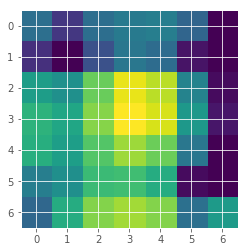

In [13]:
plt.imshow(sample_feature_map[0,:,:,0])

In [14]:
utils.show_graph(graph.as_graph_def())

In [15]:
with open('../data/training_data.pkl','rb') as fhdl:
    (out_train_image,out_train_bbs,out_train_imgsize,out_train_masks,out_train_cls_target,out_train_reg_target) = pickle.load(fhdl)

In [16]:
with open('../data/val_data.pkl','rb') as fhdl:
    (out_val_image,out_val_bbs,out_val_imgsize,out_val_masks,out_val_cls_target,out_val_reg_target) = pickle.load(fhdl)

In [17]:
box_tuple = [[16, 16],
 [32, 32],
 [48, 48],
 [64, 64],
 [96, 96],
 [128, 128],
 [192, 192],
 [256, 256],
 [512, 512]]

In [18]:
imgindex = random.randint(0,len(out_train_image))
import cv2

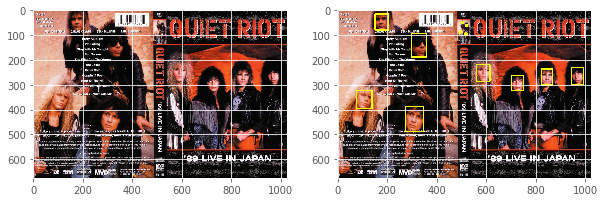

In [19]:
sample_image = plt.imread('../data/WIDER_train/images/{}'.format(out_train_image[imgindex]))
cls_target = out_train_cls_target[imgindex]
reg_target = out_train_reg_target[imgindex]
one_mask = out_train_masks[imgindex]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sample_image)
for _,idx,idy,idbox in np.asarray(np.where(cls_target[:,:,:,:,1] == 1)).T:
    rx,ry = idx * 32 + 16,idy * 32 + 16
    boxw,boxh = box_tuple[idbox]
    w_delta,h_delta,w_rat,h_rat = reg_target[0,idx,idy,idbox]
    x_center = int(rx + boxw * w_delta)
    y_center = int(ry + boxh * h_delta)
    
    x_width = int(boxw * np.exp(w_rat))
    y_height = int(boxh * np.exp(h_rat))
    
    cv2.rectangle(sample_image,(x_center - x_width // 2,y_center - y_height // 2),(x_center + x_width // 2,y_center + y_height // 2),(256,256,0),4)
plt.subplot(1,2,2)
plt.imshow(sample_image)

In [20]:
768 // 32

24

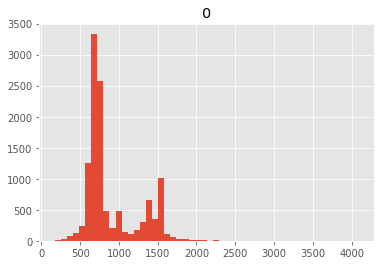

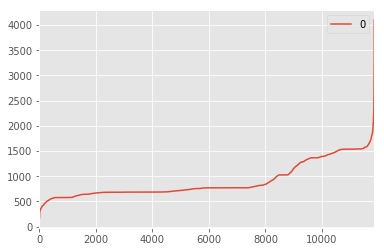

In [21]:
pd.DataFrame([i[0] for i in out_train_imgsize]).hist(bins=50)
pd.DataFrame(sorted([i[0] for i in out_train_imgsize])).plot()

In [22]:
class MultiIndex():
    def __init__(self,data):
        self.data = data
    def __getitem__(self,indexs):
        retval = []
        for i in indexs:
            retval.append(self.data[i])
        return retval
    @property
    def shape(self):
        return [len(self.data),]

In [23]:
mi = MultiIndex([1,2,3,4])
mi.shape,mi[[2,3]]

([4], [3, 4])

In [24]:
train_dataset = utils.Dataset(
    out_train_image,
    MultiIndex(out_train_masks),
    MultiIndex(out_train_cls_target),
    MultiIndex(out_train_reg_target))

In [25]:
val_dataset = utils.Dataset(
    out_val_image,
    MultiIndex(out_val_masks),
    MultiIndex(out_val_cls_target),
    MultiIndex(out_val_reg_target))

In [26]:
one_imgurl,one_mask,cls_target,reg_target = train_dataset.next_batch(1)

In [27]:
one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]

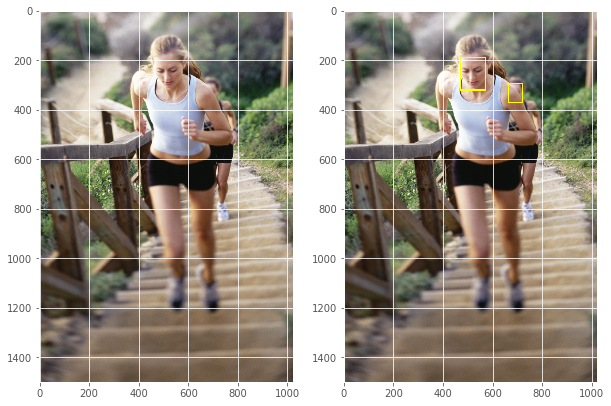

In [28]:

sample_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sample_image)
for _,idx,idy,idbox in np.asarray(np.where(cls_target[:,:,:,:,1] == 1)).T:
    rx,ry = idx * 32 + 16,idy * 32 + 16
    boxw,boxh = box_tuple[idbox]
    w_delta,h_delta,w_rat,h_rat = reg_target[0,idx,idy,idbox]
    x_center = int(rx + boxw * w_delta)
    y_center = int(ry + boxh * h_delta)
    
    x_width = int(boxw * np.exp(w_rat))
    y_height = int(boxh * np.exp(h_rat))
    
    cv2.rectangle(sample_image,(x_center - x_width // 2,y_center - y_height // 2),(x_center + x_width // 2,y_center + y_height // 2),(256,256,0),4)
plt.subplot(1,2,2)
plt.imshow(sample_image)

In [29]:
if os.path.exists('models/{}'.format(MODEL_NAME)):
    print('dir exists')
else:
    os.mkdir('models/{}'.format(MODEL_NAME))

In [30]:
cls_target[:,:,:,:,1].shape

(1, 32, 46, 9)

In [31]:
np.copy(cls_target[:,:,:,:,1]).shape,one_mask.shape

((1, 32, 46, 9), (1, 32, 46, 9))

In [32]:
def add_random_spot(one_mask):
    one_mask_shape = one_mask.shape
    one_mask = one_mask.reshape(-1)
    if np.sum(one_mask) <= 64:
        num_addmask = 64
    else:
        num_addmask = int(min(np.sum(one_mask),len(one_mask) - np.sum(one_mask)))
    for i in range(num_addmask):
        one_mask[random.randint(0,len(one_mask) - 1)] = 1
    one_mask = one_mask.reshape(one_mask_shape)
    return one_mask

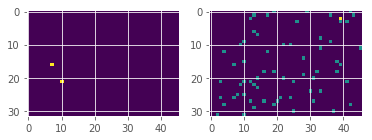

In [33]:
one_mask = np.copy(cls_target[:,:,:,:,1])
plt.subplot(1,2,1)
plt.imshow(np.sum(one_mask,-1)[0])
plt.subplot(1,2,2)
plt.imshow(np.sum(add_random_spot(one_mask),-1)[0])

In [34]:
reg_target.shape

(1, 32, 46, 9, 4)

In [35]:
cls_target.shape

(1, 32, 46, 9, 2)

In [36]:
32 * 54 * 9

15552

In [37]:
32 * 54 * 36 // 4

15552

In [38]:
with graph.as_default():
    #vgg_model.load_weights(sess)
    sess.run(tf.global_variables_initializer())
    vgg_model.load_weights(sess)
    #sample_feature_map = sess.run(feature_map,feed_dict={input_image:np.ones(shape=(1,224,224,3))})

INFO:tensorflow:Restoring parameters from /tmp/tmp36nea4mz


In [41]:
train_epoch = 1
train_batch = 0

In [42]:
restore = True
EPOCHS = 40
BATCH_PER_EPOCH = len(train_images) // BATCH_SIZE
begining_learning_rate = 1e-4
decay_epoch = 20

for one_epoch in range(train_epoch,EPOCHS + 1):
    train_dataset = utils.Dataset(
    out_train_image,
    MultiIndex(out_train_masks),
    MultiIndex(out_train_cls_target),
    MultiIndex(out_train_reg_target))
    
    pb = utils.ProgressBar(worksum=BATCH_PER_EPOCH // 2)
    pb.startjob()
    for one_batch in range(1,BATCH_PER_EPOCH // 2 + 1):
        if restore == True and one_batch < train_batch:
            pb.auto_display = False
            pb.complete(1)
            pb.auto_display = True
            continue
        else:
            restore = False
        one_imgurl,one_mask,cls_target,reg_target = train_dataset.next_batch(1)
        one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]
        one_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))
        one_image = np.transpose(one_image,[1,0,2])
        one_image = np.expand_dims(one_image,0)
        
        try:
            batch_lr = begining_learning_rate * 0.1 ** (max(one_epoch - decay_epoch + 10,0) // 10)
            one_mask = np.copy(cls_target[:,:,:,:,1])
            one_mask = add_random_spot(one_mask)
            reg_target = reg_target.reshape(list(reg_target.shape[:3]) + [-1,])

            batch_train_summary_op,_,batch_cls_loss,batch_reg_loss,batch_total_loss,step_value = sess.run([summary_op,train_op,cls_loss,reg_loss,total_loss,global_step],feed_dict={
                learning_rate:batch_lr, 
                input_image:one_image,
                mask_input:one_mask,
                cls_input:cls_target[:,:,:,:,1],
                reg_input:reg_target
            })
            pb.info = "EPOCH {} BATCH {} lr {} cls_loss {:.2f} reg_loss {:.2f} total_loss {:.2f}".format(one_epoch,one_batch,
                    batch_lr,batch_cls_loss,batch_reg_loss,batch_total_loss)
            train_summary_writer.add_summary(batch_train_summary_op,step_value)
        except (KeyboardInterrupt,SystemExit):
            raise
        except:
            #traceback.print_exc()
            pass
            #print()
            #print()
            #break
            
        pb.complete(1)
    with graph.as_default():
        saver = tf.train.Saver(tf.global_variables())
        saver.save(sess,"models/{}/model_{}".format(MODEL_NAME,one_epoch))


EPOCH 40 BATCH 6440 lr 1.0000000000000002e-07 cls_loss 0.07 reg_loss 0.09 total_loss 0.15 100.00 % [==================================================>] 6440/6440 	 used:2143s eta:0 s sss

In [295]:
start = time.time()
for i in range(100):
    one_imgurl,one_mask,cls_target,reg_target = train_dataset.next_batch(1)
    one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]
    one_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))
    one_image = np.transpose(one_image,[1,0,2])
    one_image = np.expand_dims(one_image,0)
end = time.time()
print(end - start)

1.6141579151153564


In [296]:
with graph.as_default():
    saver = tf.train.Saver(tf.global_variables())
    saver.restore(sess,"models/{}/model_latest".format(MODEL_NAME))


INFO:tensorflow:Restoring parameters from models/3_12_rpn_sigmoid/model_latest


In [297]:
one_image.shape,one_mask.shape

((1, 1024, 1032, 3), (1, 32, 32, 9))

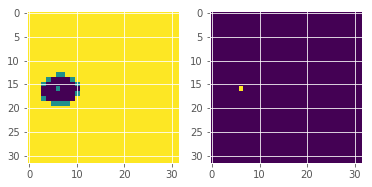

In [298]:
plt.subplot(1,2,1)
plt.imshow(np.sum(one_mask[0],axis=-1))
plt.subplot(1,2,2)
plt.imshow(np.sum(cls_target[:,:,:,:,1][0],axis=-1))

In [117]:
one_imgurl,one_mask,cls_target,reg_target = train_dataset.next_batch(1)
one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]
one_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))
one_image = np.transpose(one_image,[1,0,2])
one_image = np.expand_dims(one_image,0)

one_mask = np.copy(cls_target[:,:,:,:,1])
one_mask = add_random_spot(one_mask)
reg_target = reg_target.reshape(list(reg_target.shape[:3]) + [-1,])

np.sum(np.sum(sess.run(reg_result,feed_dict={
            learning_rate:batch_lr,
            input_image:one_image,
            mask_input:one_mask,
            cls_input:cls_target,
            reg_input:reg_target
        }).reshape(-1,4),axis=-1) * cls_target[:,:,:,:,1].reshape(-1))

In [118]:
one_cls_result,one_reg_result = sess.run([cls_result,reg_result],feed_dict={
            input_image:one_image,

        })

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa010c99a58>]], dtype=object)

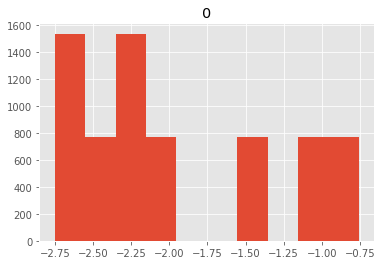

In [119]:
pd.DataFrame(one_cls_result.reshape(-1)).hist()

In [120]:
one_cls_result.shape

(1, 32, 24, 9)

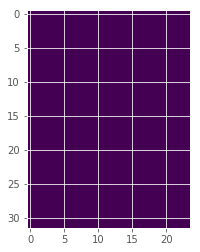

In [121]:
plt.imshow(np.sum(one_cls_result.reshape(32,-1,9) > 4,axis=-1))

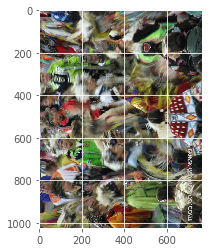

In [122]:
plt.imshow(one_image[0])

In [123]:
one_image.shape

(1, 1024, 768, 3)

In [124]:
one_reg_result = one_reg_result.reshape(list(one_reg_result.shape[:-1]) + [9,4])

In [125]:
from nms import non_max_suppression_fast

In [126]:
np.argsort([1,2,3])

array([0, 1, 2])

In [127]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

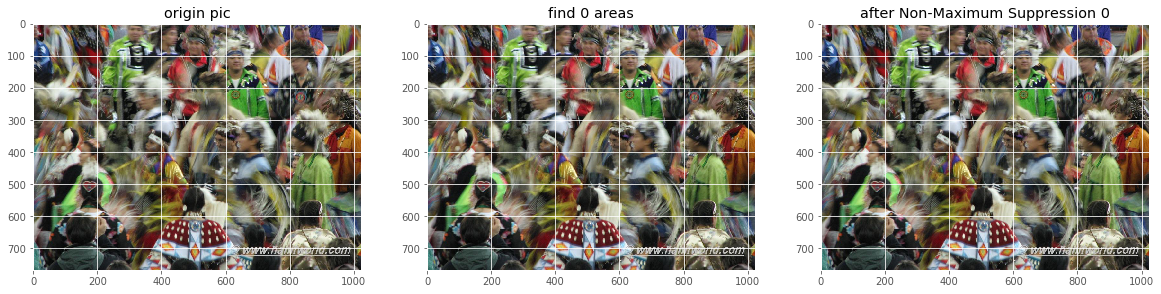

In [128]:
import cv2
sample_image = np.copy(np.transpose(one_image[0],[1,0,2]))
number_of_box = 100
threshold = sorted(one_cls_result.reshape(-1))[-number_of_box]
boxes = []
boxprob = []

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(sample_image)
plt.title('origin pic')
for _,idx,idy,idbox in np.asarray(np.where(one_cls_result > threshold)).T:
    rx,ry = idx * 32 + 16,idy * 32 + 16
    boxw,boxh = box_tuple[idbox]
    w_delta,h_delta,w_rat,h_rat = one_reg_result[0,idx,idy,idbox]
    x_center = int(rx + boxw * w_delta)
    y_center = int(ry + boxh * h_delta)
    
    x_width = int(boxw * np.exp(w_rat))
    y_height = int(boxh * np.exp(h_rat))
    
    cv2.rectangle(sample_image,(x_center - x_width // 2,y_center - y_height // 2),(x_center + x_width // 2,y_center + y_height // 2),(256,256,0),4)
    boxes.append((x_center - x_width // 2,y_center - y_height // 2,x_center + x_width // 2,y_center + y_height // 2))
    boxprob.append(one_cls_result[0,idx,idy,idbox])
plt.subplot(1,3,2)
plt.imshow(sample_image)
plt.title("find {} areas".format( len(np.asarray(np.where(one_cls_result > threshold)).T)))

sample_image = np.copy(np.transpose(one_image[0],[1,0,2]))
boxes = np.asarray(boxes)
boxprob = sigmoid(np.asarray(boxprob))
superssed_box = non_max_suppression_fast(boxes,0.4,probs=boxprob)
for x1,y1,x2,y2 in superssed_box:
    cv2.rectangle(sample_image,(x1,y1),(x2,y2),(256,256,0),4)
plt.subplot(1,3,3)
plt.imshow(sample_image)
plt.title("after Non-Maximum Suppression {}".format(len(superssed_box)))

In [544]:
number_of_box = 100
pb = utils.ProgressBar(worksum=len(out_train_image))
pb.startjob()
train_predicted_box = []
for one_url in out_train_image:
    one_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))
    one_image = np.transpose(one_image,[1,0,2])
    one_image = np.expand_dims(one_image,0)
    one_cls_result,one_reg_result = sess.run([cls_result,reg_result],feed_dict={
            input_image:one_image,
        })
    one_reg_result = one_reg_result.reshape(list(one_reg_result.shape[:-1]) + [9,4])
    threshold = sorted(one_cls_result.reshape(-1))[-number_of_box]
    boxes = []
    boxprob = []
    
    for _,idx,idy,idbox in np.asarray(np.where(one_cls_result > threshold)).T:
        rx,ry = idx * 32 + 16,idy * 32 + 16
        boxw,boxh = box_tuple[idbox]
        w_delta,h_delta,w_rat,h_rat = one_reg_result[0,idx,idy,idbox]
        x_center = int(rx + boxw * w_delta)
        y_center = int(ry + boxh * h_delta)

        x_width = int(boxw * np.exp(w_rat))
        y_height = int(boxh * np.exp(h_rat))

        #cv2.rectangle(sample_image,(x_center - x_width // 2,y_center - y_height // 2),(x_center + x_width // 2,y_center + y_height // 2),(256,256,0),4)
        boxes.append((x_center - x_width // 2,y_center - y_height // 2,x_center + x_width // 2,y_center + y_height // 2))
        boxprob.append(one_cls_result[0,idx,idy,idbox])
    boxes,boxprob = np.asarray(boxes),np.asarray(boxprob)
    superssed_box = non_max_suppression_fast(boxes,0.4,probs=boxprob)
    #for x1,y1,x2,y2 in superssed_box:
    #    cv2.rectangle(sample_image,(x1,y1),(x2,y2),(256,256,0),4)
    #plt.imshow(sample_image)
    #plt.title("after Non-Maximum Suppression {}".format(len(superssed_box)))
    train_predicted_box.append(superssed_box)
    pb.complete(1)

 100.00 % [==================================================>] 11854/11854 	 used:1320s eta:0 ss

In [549]:
with open('./data/training_data_predicted_boxes.pkl','wb') as whdl:
    pickle.dump(train_predicted_box,whdl)